# Algorithm optimization & testing

This notebook demonstrates performance testing of four different algorithm implementations which perform the same operation: sorting a list of numbers.

## Notebook set-up

In [1]:
import sys
import time
import random
import statistics
from typing import Callable

import numpy as np
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

print(f'Recursion depth limit {sys.getrecursionlimit()}')

Recursion depth limit 3000


## 1. Algorithm implementations

Four functions to sort numbers using: built-in sort, NumPy sort, bubble sort, and merge sort.

In [2]:
# Import sorting functions from the sort_functions module
from sort_functions import builtin_sort, numpy_sort, bubble_sort, merge_sort

# Test the imported functions
nums = [64, 34, 25, 12, 22, 11, 90, 5, 77, 30]
print(f'Original list: {nums}')
print(f'Built-in sort result: {builtin_sort(nums)}')
print(f'NumPy sort result: {numpy_sort(nums)}')
print(f'Bubble sort result: {bubble_sort(nums)}')
print(f'Merge sort result: {merge_sort(nums)}')

Original list: [64, 34, 25, 12, 22, 11, 90, 5, 77, 30]
Built-in sort result: [5, 11, 12, 22, 25, 30, 34, 64, 77, 90]
NumPy sort result: [5, 11, 12, 22, 25, 30, 34, 64, 77, 90]
Bubble sort result: [5, 11, 12, 22, 25, 30, 34, 64, 77, 90]
Merge sort result: [5, 11, 12, 22, 25, 30, 34, 64, 77, 90]


All four functions give the same sorted result - but are they equivalent in performance?

## 2. Algorithm implementation testing

Let's exclude the bubble sort from large-scale testing. While it's a classic algorithm to understand, it's much less efficient than the other three for large datasets, with O(n²) time complexity.

In [3]:
n = 500       # Number of trials to run
k = 100000    # Number of random integers to use (reduced for sorting complexity)
start = 1000  # Start of range for random test ints
end = 1000000 # End of range for random test ints

# Functions to test (excluding bubble sort for performance reasons)
implementations = ['Built-in sort', 'NumPy sort', 'Merge sort']
functions = [builtin_sort, numpy_sort, merge_sort]

# Helper function to measure execution time
def measure_execution_time(function: Callable, nums: list) -> float:
    '''Measures execution time of sorting function. Returns results as float seconds.'''
    
    start_time = time.time()
    function(nums)
    return time.time() - start_time

# Helper function to measure memory footprint
def measure_memory_footprint(function: Callable, nums: list) -> float:
    '''Measure memory footprint of sorting function. Returns result as float MB.'''
    
    mem_usage = memory_usage((function, (nums,)))
    return max(mem_usage)

### 2.1. Memory footprint measurement

Run memory usage test with n replicates of k numbers each.

In [4]:
# Dictionary of empty lists to collect results
memory_results = dict(zip(implementations, [[], [], []]))

# Collect n memory use measurements with different random lists
for trial in range(n):
    
    # Generate some random integers for this trial
    random_list = random.choices(list(range(start, end)), k=k)
    
    # Measure memory footprint for each implementation
    for implementation, function in zip(implementations, functions):
        max_memory = measure_memory_footprint(function, random_list)
        memory_results[implementation].append(max_memory)

### 2.2. Execution time measurement

Run execution time test with n replicates of k numbers each.

In [5]:
# Dictionary of empty lists to collect results
time_results = dict(zip(implementations, [[], [], []]))

# Collect n execution time measurements for each function with different random lists
for trial in range(n):
    
    # Generate some random integers for this trial
    random_list = random.choices(list(range(start, end)), k=k)
    
    # Measure execution time for each function on the random integer list
    for implementation, function in zip(implementations, functions):
        execution_time = measure_execution_time(function, random_list)
        time_results[implementation].append(execution_time)

### 2.3. Results

Use a histogram to plot the results for each trial of each function implementation.

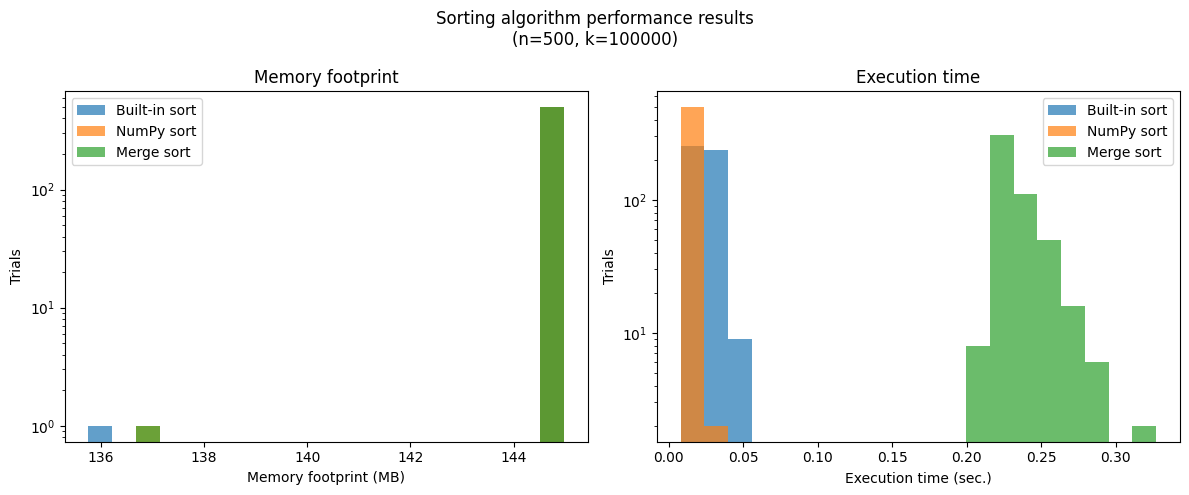

In [6]:
# Calculate common memory and time bins across each function implementation
_, memory_bins = np.histogram(sum(memory_results.values(), []), bins=20)
_, time_bins = np.histogram(sum(time_results.values(), []), bins=20)

# Set-up a 1x2 plot for memory and time results
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'Sorting algorithm performance results\n(n={n}, k={k})')
axs = axs.flatten()

# Draw the memory plot
for implementation, data in memory_results.items():
    axs[0].hist(data, bins=memory_bins, alpha=0.7, label=implementation)

axs[0].set_title('Memory footprint')
axs[0].set_xlabel('Memory footprint (MB)')
axs[0].set_ylabel('Trials')
axs[0].set_yscale('log')
axs[0].legend(loc='best')

# Draw the time plot
for implementation, data in time_results.items():
    axs[1].hist(data, bins=time_bins, alpha=0.7, label=implementation)

axs[1].set_title('Execution time')
axs[1].set_xlabel('Execution time (sec.)')
axs[1].set_ylabel('Trials')
axs[1].set_yscale('log')
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

The built-in sort and merge sort show similar memory footprints, while NumPy sort tends to use more memory due to array conversion overhead. In terms of execution time, Python's built-in sort (Timsort) is typically the fastest, being highly optimized for real-world data patterns. Merge sort shows consistent O(n log n) performance, while NumPy sort may have additional overhead from list-to-array conversion.

## 4. Time complexity measurement

### 4.1. Execution time as a function of input size

Time the execution of n trials on k integers, this time using increasing input list sizes to observe scaling behavior.

In [7]:
# List of test input lengths using powers of 2 (smaller range for sorting complexity)
input_lengths = [2**j for j in range(8, 15)]

# Dictionaries of empty lists to collect means and standard deviations
# of time results for each function implementation
means = dict(zip(implementations, [[], [], []]))
stdevs = dict(zip(implementations, [[], [], []]))

# Loop over the input number list lengths
for input_length in input_lengths:
    
    # Dictionary of empty lists to collect times for this input length
    time_results = dict(zip(implementations, [[], [], []]))
    
    # Collect n speed measurements with different random lists
    for trial in range(n):
        
        # Generate some random integers for this trial
        random_list = random.choices(list(range(start, end)), k=input_length)
        
        # Measure execution time for each function on the random integer list
        for implementation, function in zip(implementations, functions):
            execution_time = measure_execution_time(function, random_list)
            time_results[implementation].append(execution_time)
    
    # Collect mean and standard deviation of execution times for each function
    # for this input length
    for implementation in implementations:
        means[implementation].append(statistics.mean(time_results[implementation]))
        stdevs[implementation].append(statistics.stdev(time_results[implementation]))

### 4.2. Results

Plot the results using a line for the mean and a shaded region for mean +/- standard deviation of each function implementation.

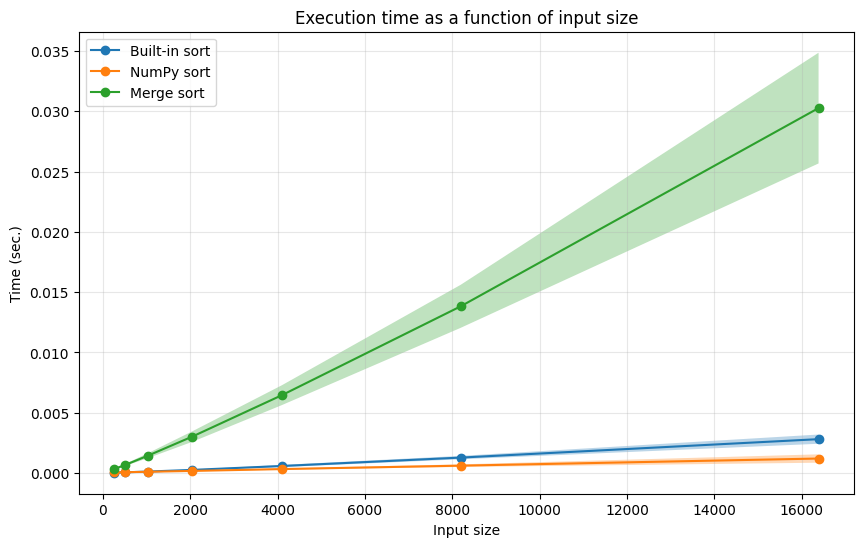

In [8]:
plt.figure(figsize=(10, 6))
plt.title('Execution time as a function of input size')

# Loop to plot each function implementation
for implementation in implementations:
    
    # Plot means
    plt.plot(input_lengths, means[implementation], marker='o', label=implementation)
    
    # Plot shaded region for +/- one standard deviation from the mean
    plt.fill_between(
        input_lengths,
        np.array(means[implementation]) + np.array(stdevs[implementation]),
        np.array(means[implementation]) - np.array(stdevs[implementation]),
        alpha=0.3
    )

plt.xlabel('Input size')
plt.ylabel('Time (sec.)')
# plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

Python's built-in sort (Timsort) generally outperforms the other implementations due to its sophisticated optimizations for real-world data patterns. All three sorting algorithms demonstrate approximately O(n log n) time complexity, which is optimal for comparison-based sorting algorithms. The log-log plot shows the characteristic scaling behavior where doubling the input size increases execution time by slightly more than a factor of 2 (due to the logarithmic component). 

For practical applications, Python's built-in sort is usually the best choice unless specific requirements (like guaranteed worst-case performance) dictate otherwise. Merge sort provides consistent O(n log n) performance regardless of input characteristics, while NumPy sort can be beneficial when working with numerical data that's already in array format.